In [1]:
from IPython.display import Image

from IPython.display import SVG

### Abstract

In this article we use skip-thought vectors[1], a state art of sentence encoder model,
to evaluate the performance of textual entailment task.

### Introduction

Textual entailment[2] is a imporant task in natural language processing.

It's a directional relation between two text fragments,
one  is called as *Text(T)*, the other is called as *Hypothesis(H)*.

There are three defferent relations between *T* and *H*:
1. T entails H
2. T contradicts H
3. neutral relation


### Related works

You can see related textual entailment works at [SNLI](http://nlp.stanford.edu/projects/snli/)[3]

#### Skip-Thought Vectors

Skip-Thoughts uses encoder-decoder architecture like the one in [4].
It has one encoder for current sentence and two decoders for previous and next sentence.
Encoder and Decoder use single GRU[4] layer.

The following picture consists of detail equations of encoder:

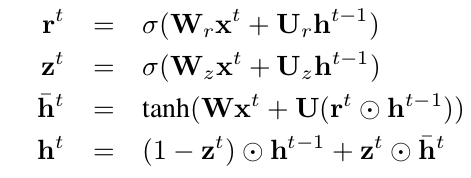

In [4]:
Image('./encoder_equations.png')

And the decoder equations are following, conditioning on the encoder output $h_i$

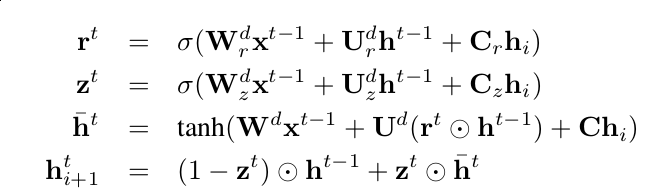

In [5]:
Image('./decoder_equations.png')

From the pulished code [skip-thoughts](https://github.com/ryankiros/skip-thoughts),
it is slightly defferent from the paper[1], you can see the reason
at [Issue 8](https://github.com/ryankiros/skip-thoughts/issues/8)

The following picture is a visualization of Skip-Thoughts model according to published training code:

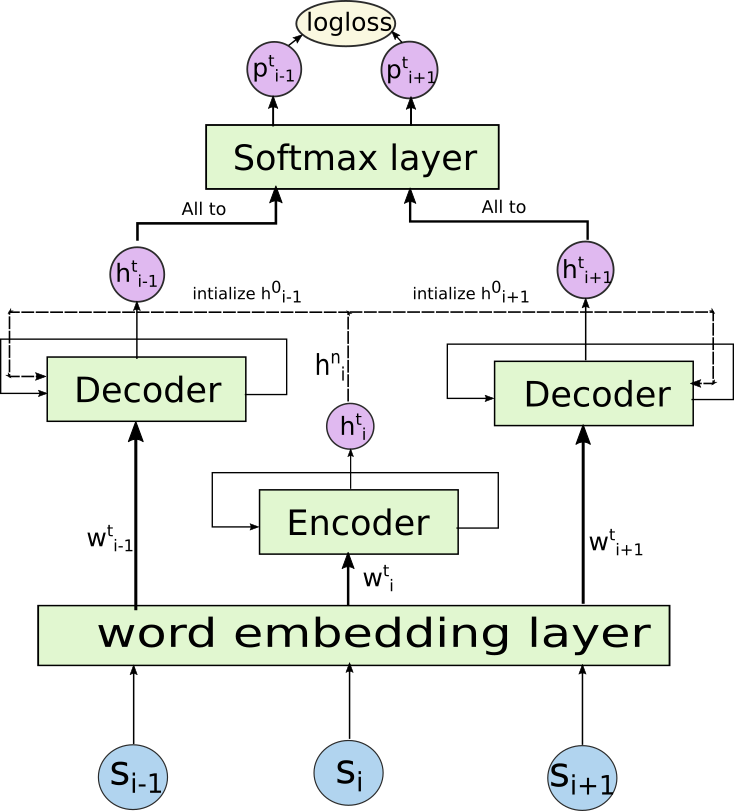

In [3]:
Image('./skip-thoughts_model.png')

After training, the encoder can convert word enbedding of sentences to sentence vectors.

### Texual entailment on skip-thoughts

Our main works are at evaluating RTE[1, 2, 3] datasets and SNLI dataset on Skip-Thoughts model.

We evaluated four methods  and a combined features method to train classifiers to predict that is *T* entails *H*.

#### encodes Text and Hypothesis to sentence vectors

We use the pre-trained *uni-skip* and *bi-skip* models at [skip-thoughts](https://github.com/ryankiros/skip-thoughts)
to get two vectors of *T* and *H*.

Sentence vector has 4800 length.

And then follow the same way of the experience semantic relatedness in the paper[1],
concatenate the two $ |v_t - v_h|$ and $v_t \cdot v_h$ vectors as features(9600 length).

Then using scikit-learn's LogisticRegressionCV to find best accuracy on test data.

#### uses word2vec cosine similarity of  word with word

We use the max cosine similarity of each word in *Hypothesis* with each word in *Text*,
then mean these max cosines, also each word in *Text* with each word in *Hypothesis*,
finally we get two features: hypothesis_mean_cosine, text_mean_cosine.

The following code get these features for a DataFrame of RTE dataset:

```python
        def handle(df):
            data_cosines = np.empty((len(df), 2))
            for index, row in df.iterrows():
                text = row.text
                hypothesis = row.hypothesis
                text = text.split()
                hypothesis = hypothesis.split()
                sims = np.zeros((len(text), len(hypothesis)))
                for i, w1 in enumerate(text):
                    for j, w2 in enumerate(hypothesis):
                        if w1 not in self.word2vec or w2 not in self.word2vec:
                            sim = 0.0
                        else:
                            sim = self.word2vec.similarity(w1, w2)
                        sims[i, j] = sim
                text_max_cosines = np.max(sims, axis=1)
                text_mean_cosine = np.mean(text_max_cosines)
                hypothesis_max_cosines = np.max(sims, axis=0)
                hypothesis_mean_cosine = np.mean(hypothesis_max_cosines)
                data_cosines[index, 0] = text_mean_cosine
                data_cosines[index, 1] = hypothesis_mean_cosine
            return data_cosines
```

Using the two features trains a Logistic Regression classifier,
through scikit-learn's LogisticRegressionCV to find best hyperprarmeter C.

#### concatenate sentence vectors and  cosine similarity features

We concatenate preprocessed *Text* *Hypothesis* vectors and cosine similarity features(9602 length),
and also use scikit-learn's LogisticRegressionCV

#### uses decoder output by conditioning on encoder output

We use pre-trained deocder *Hypothesis* output conditioning on pre-trained encoder *Text* output as features,
and use pre-trained deocder *Text* output conditioning on pre-trained encoder *Hypothesis* output as features,
we also use both *uni-skip* and *bi-skip*

We use the following network architecture convert *Text* and *Hypothesis* to vectors:

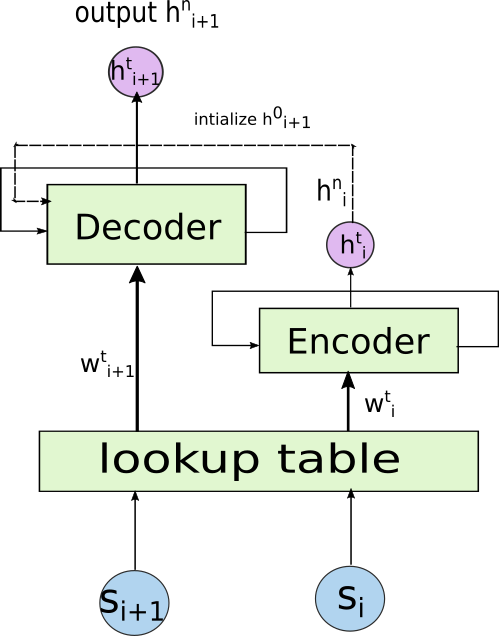

In [6]:
Image('./te_decoder_on_encoder.png')

We use the following network architecture to train the classifier that predicts entailment or not:

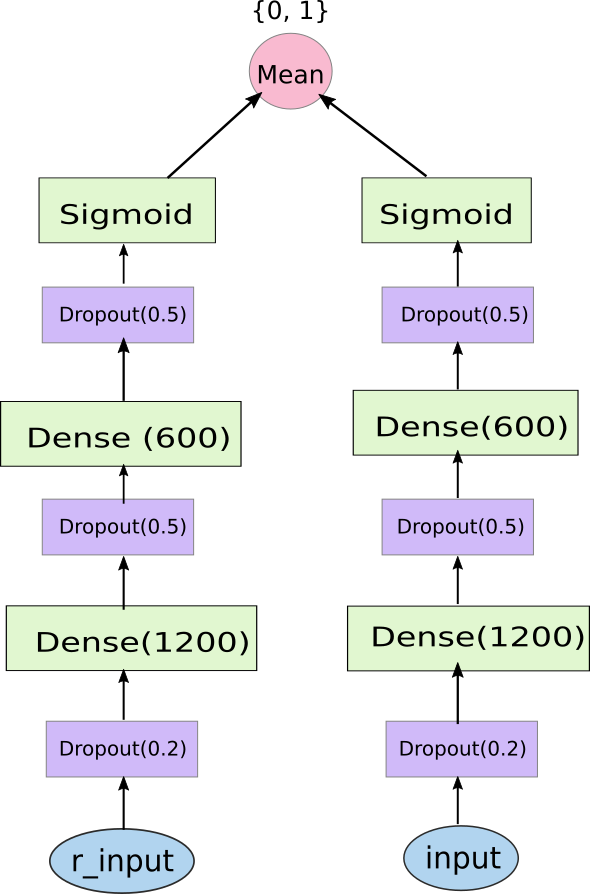

In [7]:
Image('./rte_decoder_mlp.png')

#### changes objective of Skip-Thoughts model to tranfer learning a classifier

We use the following neural networks to directly train a textual entailment classifier:

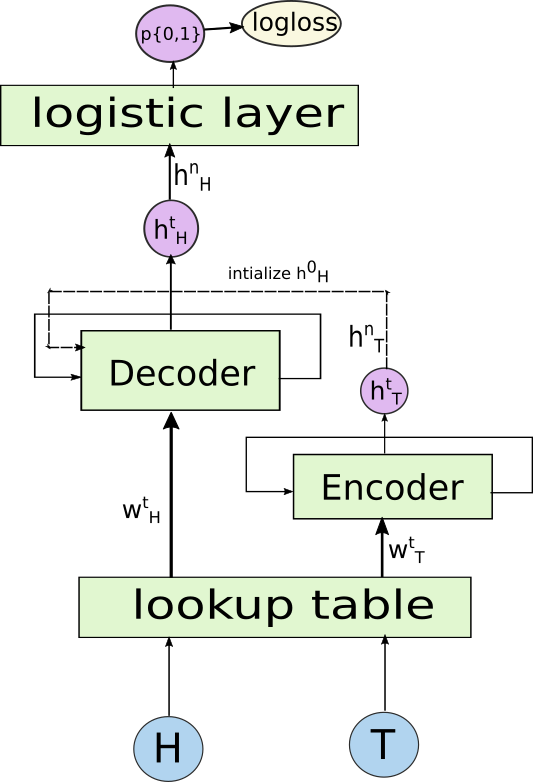

In [12]:
Image('./logisticregression_decoder_on_encoder.png')

We use three approach to tranfer learning the above network:
1. use pre-train encoder and f_decoder weights
2. only use pre-train encoder weights
3. don't use pre-train weights

We use dropout(0.5) at encoder and decoder outputs,
also test no dropout using approach 1.

The logistic layer is intialized using a uniform distribution in [-0.1, 0.1].

From the results of the three approach experiments, the first way performs better at test accuracy.

### Experiments

In [14]:
import pandas as pd

We evaluate our approach at RTE[1, 2, 3] and SNLI datasets.

Because of memory limits, we only use 1 / 3 train data of SNLI,
and convert contradiction and neutral as noentailment as a 2-class
problem, and use a neural network with no hidden layers to do logistic
regression.

We use RTE[1, 2, 3] shipped with nltk-data, and use `from nltk.corpus import rte`
to load RTE datasets.

#### test accuracy of the first three methods on RTE and SNLI datasets

In [31]:
logistic_results = pd.read_excel('./logistic_results.xls')
logistic_results

,RTE-1,RTE-2,RTE-3,"RTE-1,2,3",SNLI
sentence-vector,0.53625,0.53625,0.56000,0.56750,0.78000
cosine-similarity,0.53750,0.57250,0.61125,0.57917,0.67752
Combined,0.56250,0.55375,0.62250,0.58208,0.79850


We also train a mlp classifier on SNLI dataset same as the one uses
at using decoder output by conditioning on encoder output.

The best test accuracy is 81.55%

The following figure is the learning curve:

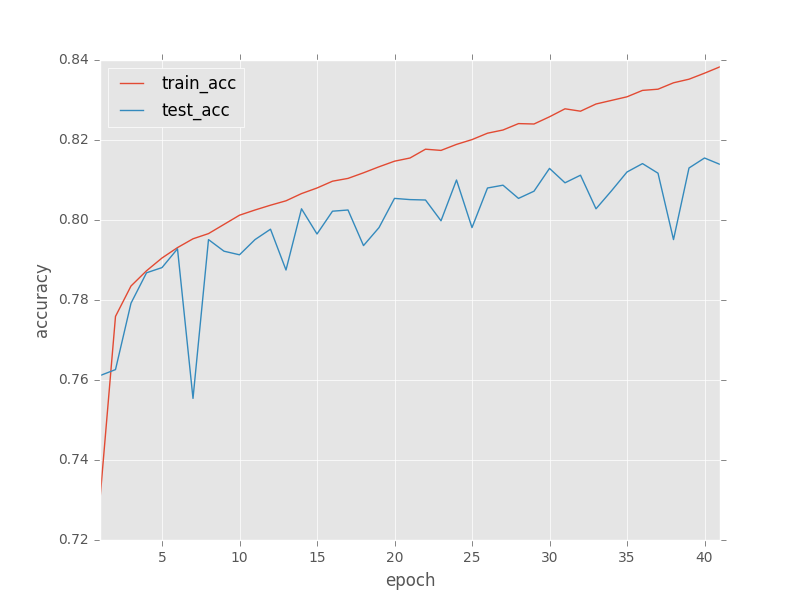

In [36]:
Image('./encoded_snli_mlp.png')

#### the learning curves of uses decoder output by conditioning on encoder output

Because of time reason and memory limit, we just use the method on RTE datasets.

The following three figures are the learning curves of neural network using Lasagne.

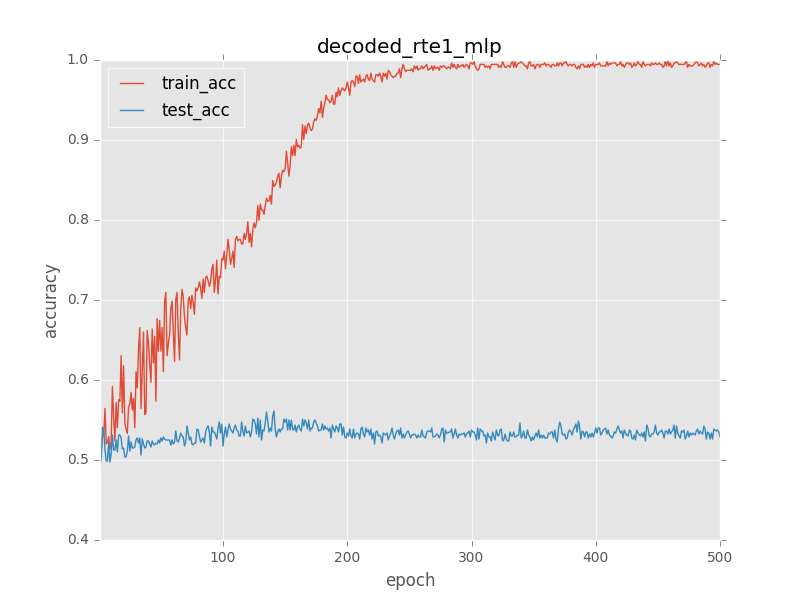

In [33]:
Image('./decoded_rte1_mlp.png')

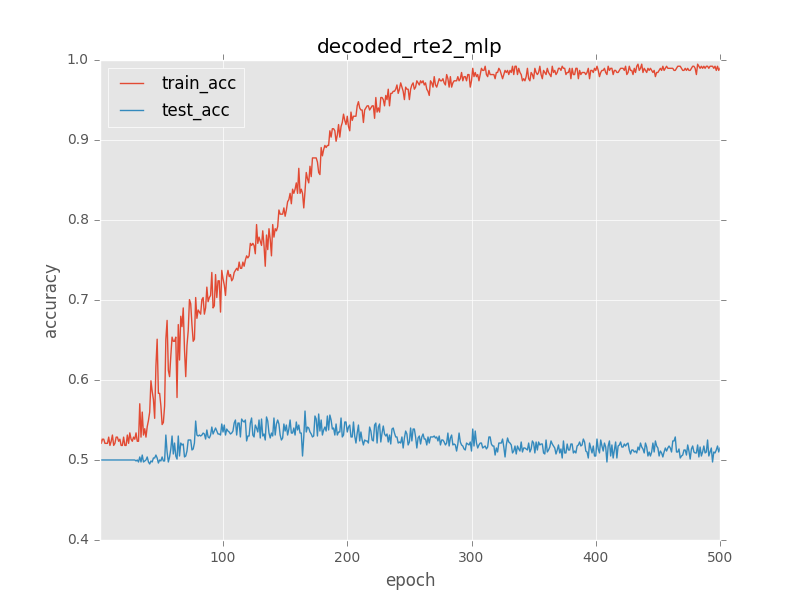

In [34]:
Image('./decoded_rte2_mlp.png')

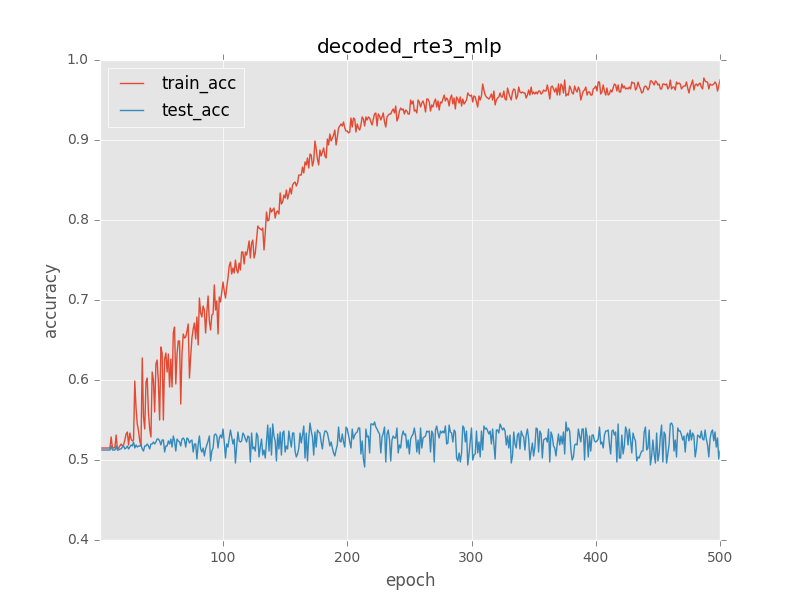

In [35]:
Image('./decoded_rte3_mlp.png')

#### the learning curves of changes objective of Skip-Thoughts model to tranfer learning a classifier

Same reason, we only evaluate the method on RTE datasets

##### The following three figures are the no dropout version of  this method using both  pre-train encoder and decoder 

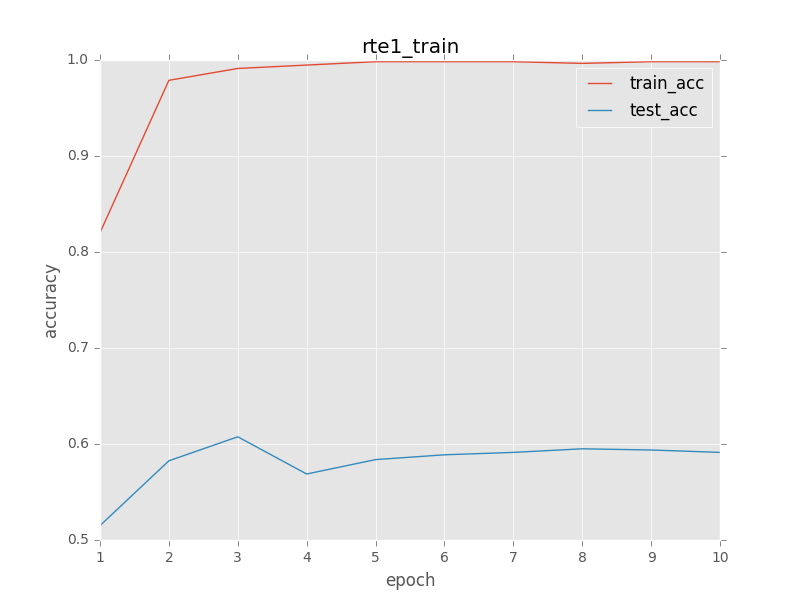

In [37]:
Image('./rte1_train.png')

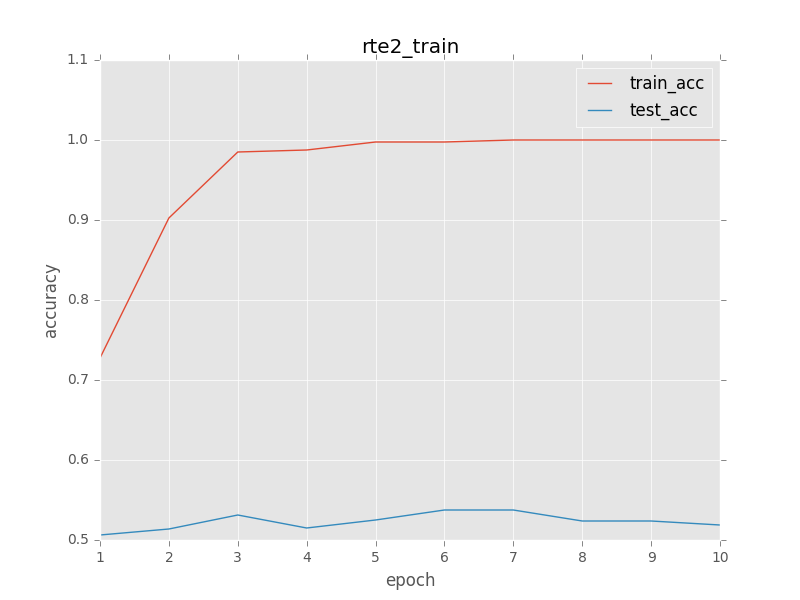

In [38]:
Image('./rte2_train.png')

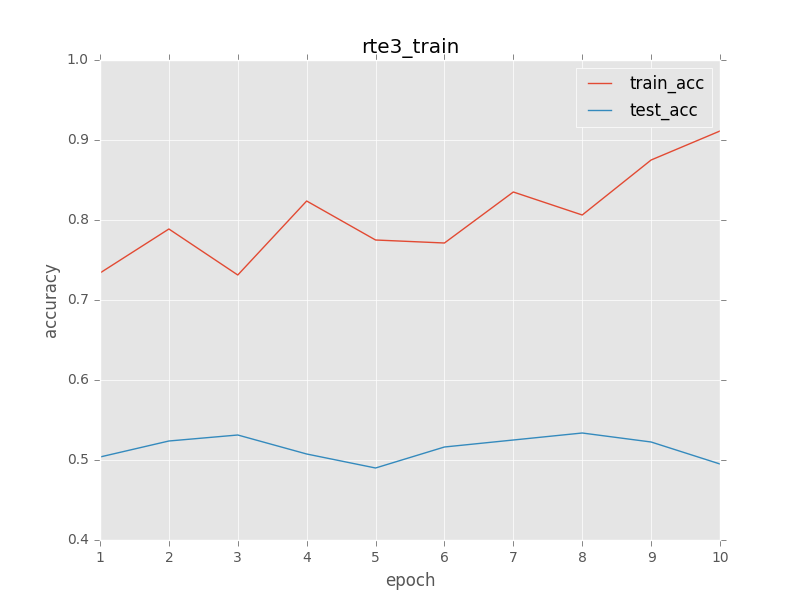

In [39]:
Image('./rte3_train.png')

##### And the following nine figures are all using dropout version of  this method

###### Pre-train encoder and decoder:

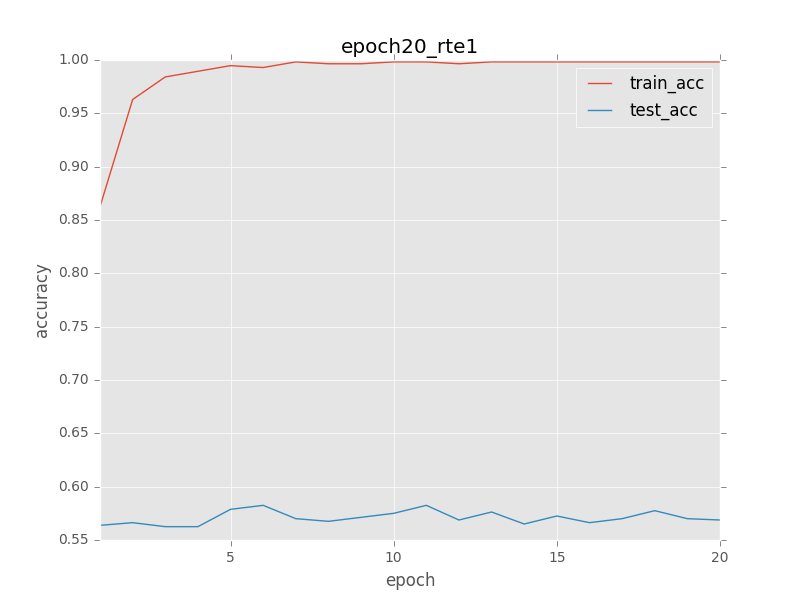

In [43]:
Image('./epoch20_rte1.png')

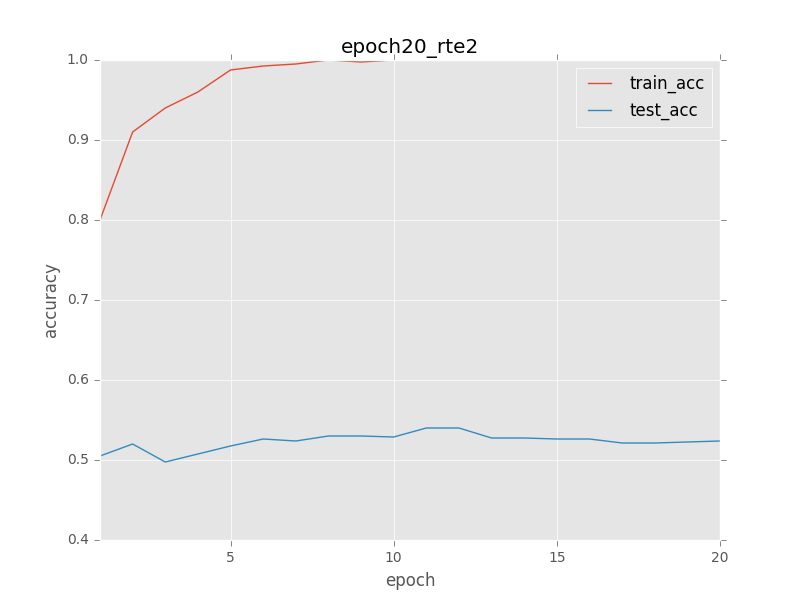

In [44]:
Image('./epoch20_rte2.png')

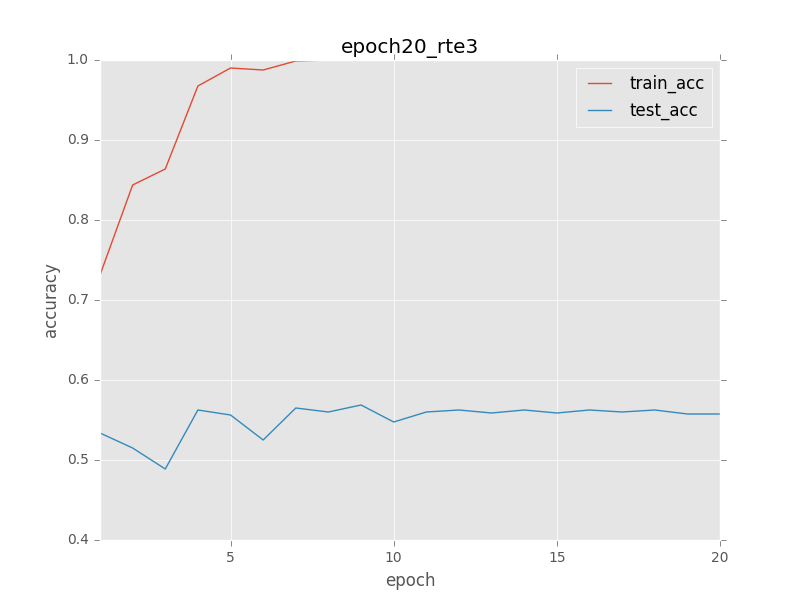

In [45]:
Image('./epoch20_rte3.png')

###### No pre-train encoder and decoder:

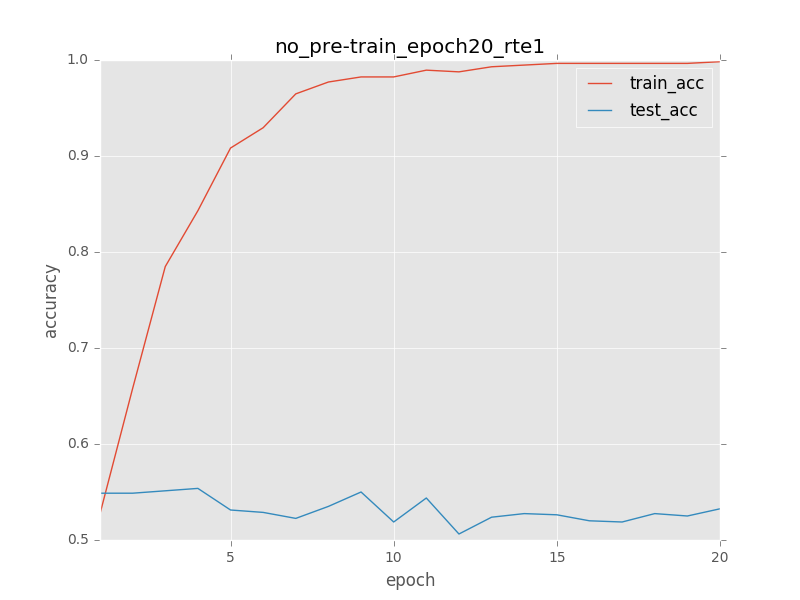

In [40]:
Image('./no_pre-train_epoch20_rte1.png')

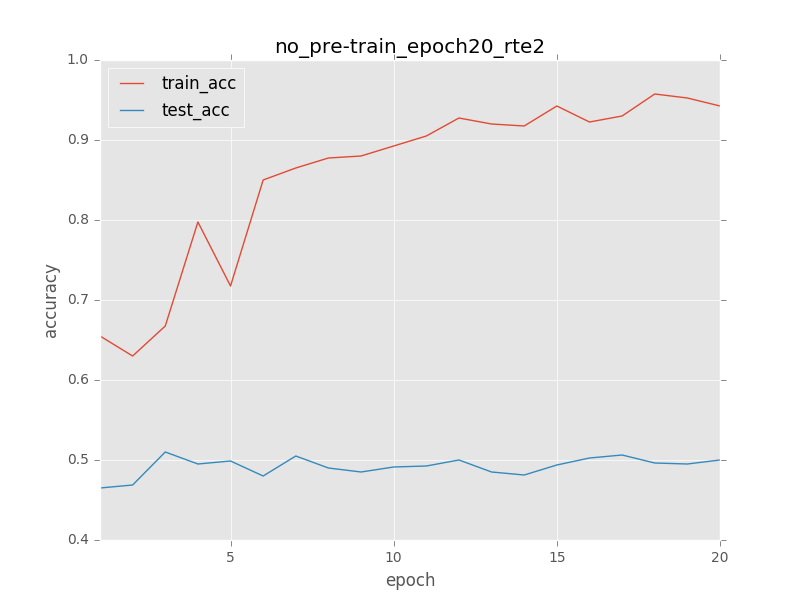

In [41]:
Image('./no_pre-train_epoch20_rte2.png')

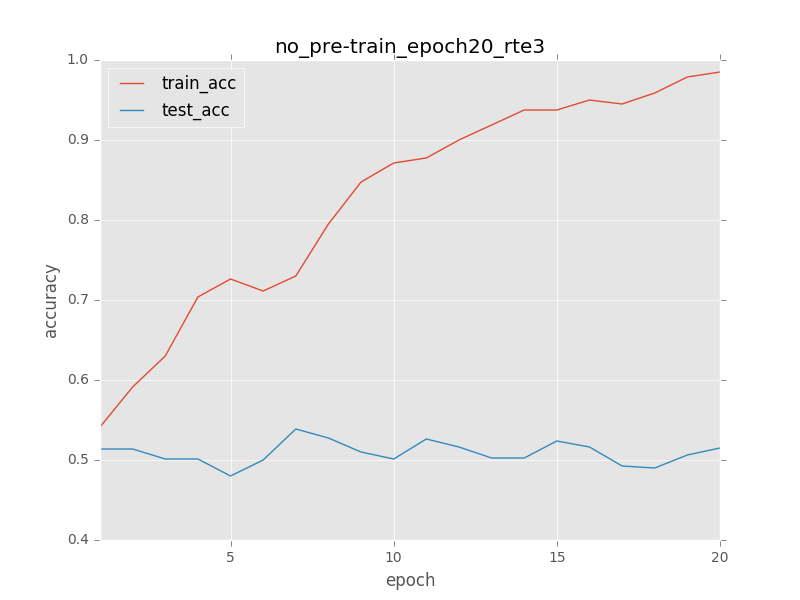

In [42]:
Image('./no_pre-train_epoch20_rte3.png')

###### just pre-train encoder:

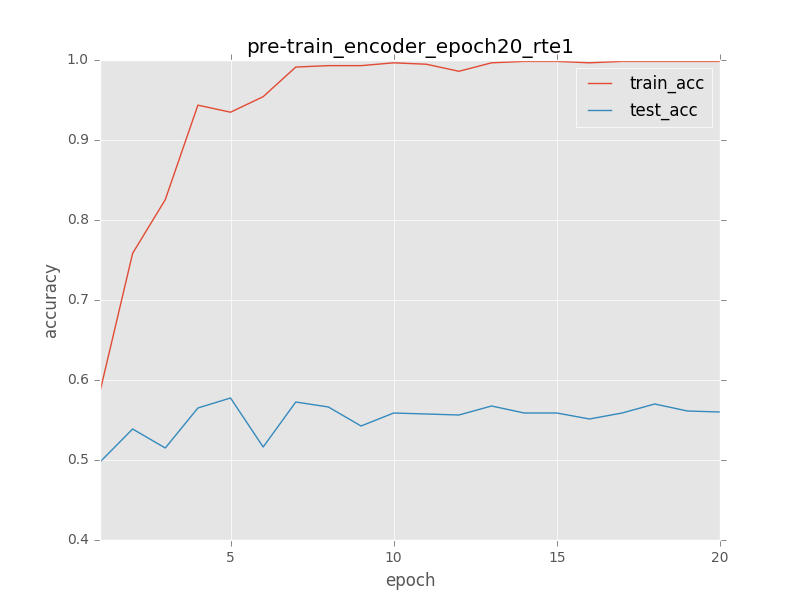

In [46]:
Image('./pre-train_encoder_epoch20_rte1.png')

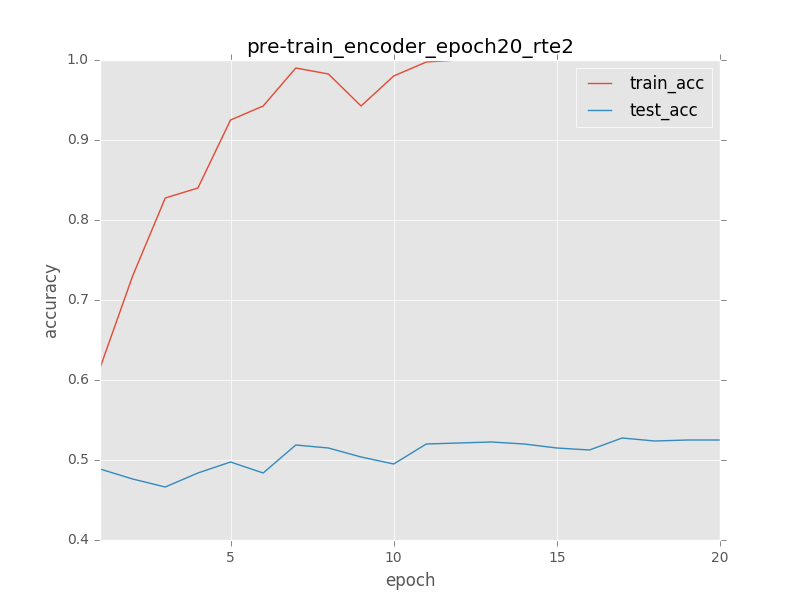

In [47]:
Image('./pre-train_encoder_epoch20_rte2.png')

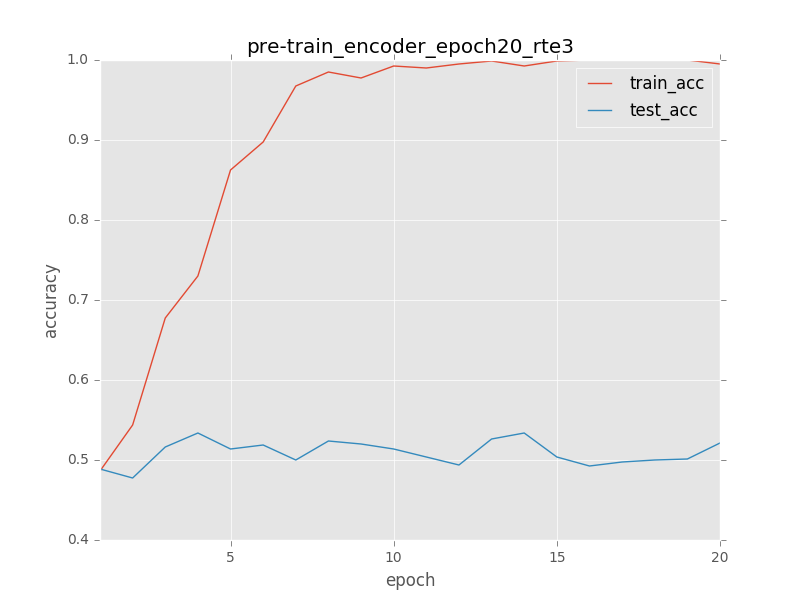

In [48]:
Image('./pre-train_encoder_epoch20_rte3.png')

### Limitation

RTE datasets have too small train samples.

(TODO)

### Future works

We prepare to evaluate these methods on Chinese texutal entailment

(TODO)

### Conclusion

Pre-train Skip-Thoughts model can slightly improve textual entailment task,
and simple word2vec cosine similarity features also provide good results when
train data is too small.

(TODO)

#### References

1. Skip-Thought Vectors Ryan Kiros, Yukun Zhu, Ruslan Salakhutdinov, Richard S. Zemel, Antonio Torralba, Raquel Urtasun, Sanja Fidler
2. https://en.wikipedia.org/wiki/Textual_entailment
3.  Samuel R. Bowman, Gabor Angeli, Christopher Potts, and Christopher D. Manning. 2015. A large annotated corpus for learning natural language inference. In Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing (EMNLP)
4. Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation
Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, Yoshua Bengio